In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numba import njit, jit
from itertools import permutations

import random

In [170]:
B = 25
SHINGLES = 2
PERMUTATIONS = 250
TRESHOLD = 0.7

print(1 - np.power((1 - np.power(TRESHOLD, PERMUTATIONS / B)), B))
print(PERMUTATIONS/B)

0.5114698329575695
10.0


In [171]:
df = pd.read_csv("news_articles_small_monkey.csv")
# df = pd.read_csv("news_articles_large.csv")

print(df.head())

   News_ID                                            article
0        0  The man ate a banana while the monkey looked hurt
1        1  The man ate a banana while the monkey looked j...
2        2  The man ate a coconut while the monkey looked ...
3        3  The man ate a banana while the ape looked jealous
4        4  The Philippine subsidiary of US telecommunicat...


# Jaccard similarity

In [172]:
shingles = SHINGLES
shingles_dict = dict()

In [173]:
def apply_shingles(input):
    s = set()
    l = input.split(' ')
    for ind in range((len(l) - shingles + 1)):
        word = ' '.join(l[ind:ind+shingles])
        if word not in shingles_dict:
            shingles_dict[word] = len(shingles_dict)
        s.add(shingles_dict[word])
    return s
        
df["shingles"] = df["article"].apply(apply_shingles)
print(df.head())

   News_ID                                            article  \
0        0  The man ate a banana while the monkey looked hurt   
1        1  The man ate a banana while the monkey looked j...   
2        2  The man ate a coconut while the monkey looked ...   
3        3  The man ate a banana while the ape looked jealous   
4        4  The Philippine subsidiary of US telecommunicat...   

                                            shingles  
0                        {0, 1, 2, 3, 4, 5, 6, 7, 8}  
1                        {0, 1, 2, 3, 4, 5, 6, 7, 9}  
2                      {0, 1, 2, 5, 6, 7, 9, 10, 11}  
3                      {0, 1, 2, 3, 4, 5, 9, 12, 13}  
4  {14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...  


In [174]:
def similarity(a, b):
    return (len(a & b) / len(a | b))

In [258]:
%%time
similarities = list()
no_repeating = set()
for ind_i, i in enumerate(df["shingles"]):
    for ind_j, j in enumerate(df["shingles"]):
        if (ind_j, ind_i) in no_repeating:
            pass
        else:
            no_repeating.add((ind_i, ind_j))
            if ind_i != ind_j:
                similarities.append(similarity(i, j))

hist = np.histogram(similarities, bins=10, range=(0, 1))

yeet
CPU times: user 7.53 s, sys: 31.6 ms, total: 7.57 s
Wall time: 7.56 s


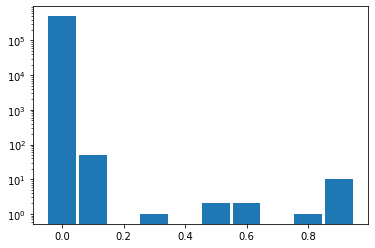

In [259]:
fig, ax = plt.subplots()
ax.bar(hist[1][:-1], hist[0], width=0.09)
ax.set_yscale("log")
plt.show()

In [260]:
print(hist)

(array([499433,     51,      0,      1,      0,      2,      2,      0,
            1,     10]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


# Create minhash

In [177]:
num_perm = PERMUTATIONS
all_shingles = np.array(list(shingles_dict.values()))

permutations = np.zeros(shape=(num_perm, len(all_shingles)), dtype=int)
sign_matrix = np.zeros(shape=(num_perm, len(df.shingles)), dtype=int)

In [178]:
%%time
for i in range(num_perm):
    cont = True
    while cont:
        cont = False
        perm = np.random.permutation(all_shingles)
        for j in range(i):
            if (permutations[j] == perm).all():
                cont = True
    permutations[i] = perm

CPU times: user 4.05 s, sys: 88.1 ms, total: 4.14 s
Wall time: 4.14 s


In [179]:
%%time
for doc_index, document in enumerate(df.shingles):
    for perm_index, perm in enumerate(permutations):
        for shingle_index, shingle in enumerate(perm):
            if shingle in document:
                sign_matrix[perm_index, doc_index] = shingle_index
                break

CPU times: user 33.5 s, sys: 0 ns, total: 33.5 s
Wall time: 33.6 s


In [180]:
print(sign_matrix)

[[18246  4859  4859 ...   691   413  1790]
 [18682 18682 19965 ...   820    26   295]
 [15407 15407 15407 ...  1406   849    47]
 ...
 [ 7953  7953  7953 ...  2062   205   383]
 [19043  1940  1940 ...   535   176   569]
 [11092 11092 11092 ...  1709   229    15]]


# Locality-Sensitive Hashing

In [181]:
bands = B

In [182]:
table = np.split(sign_matrix, bands)
htable = [dict()] * bands

candidate_pairs = set()

In [183]:
print(table[0][0][0:10])
print(table[0][1][0:10])

[18246  4859  4859  4859  1444    40   419  1266   592   477]
[18682 18682 19965 18682    61   485   312   822   399   123]


In [184]:
%%time
for band_index, band in enumerate(table):
    for row_index, row in enumerate(band.T):
        if row.tostring() in htable[band_index]:
            for candidate in htable[band_index][row.tostring()]:
                candidate_pairs.add((row_index, candidate))
            htable[band_index][row.tostring()].add(row_index)
        else:
            htable[band_index][row.tostring()] = {row_index}

CPU times: user 33.7 ms, sys: 0 ns, total: 33.7 ms
Wall time: 33.6 ms


In [211]:
print(len(candidate_pairs))

11


In [263]:
for pair in candidate_pairs:
    print(similarity(df.shingles[pair[0]], df.shingles[pair[1]]))
    print("{", df["article"][pair[0]][:50], "}; {" , df["article"][pair[1]][:50], "}")
    print()

0.9883268482490273
{ Saudi Arabia has lifted a ban on Jordanian and Pal }; { Saudi Arabia has lifted a ban on Jordanian and Pal }

0.9892086330935251
{ Syrian President Hafez al-Assad held talks here Sa }; { Syrian President Hafez al-Assad held talks here Sa }

0.9885057471264368
{ Burundi's government on Monday declared a period o }; { Burundi's government on Monday declared a period o }

0.98828125
{ Russian Prime Minister Viktor Chernomyrdin on Thur }; { Russian Prime Minister Viktor Chernomyrdin on Thur }

0.9873417721518988
{ A man was shot dead and fifteen others injured whe }; { A man was shot dead and fifteen others injured whe }

0.9878048780487805
{ The peseta nosedived to a new all-time low early F }; { The peseta nosedived to a new all-time low early F }

0.9862385321100917
{ The Pakistani government Saturday sacked four top  }; { The Pakistani government Saturday sacked four top  }

0.9887218045112782
{ McDonald's hamburger chain must pay 375,000 dollar }; { McDonald's ham